# Effect of capillary forces on $V_P$ and $V_S$ - Application to Landes sand
Modelled using *Solazzi, S. G., Bodet, L., Holliger, K., & Jougnot, D. (2021). Surface‐Wave Dispersion in Partially Saturated Soils: The Role of Capillary Forces. Journal of Geophysical Research: Solid Earth, e2021JB022074*.

### Load Packages and Routines

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Go to Python folder to import routines
if os.getcwd() != 'C:\\Olivia\\Python': 
    os.chdir('C:\\Olivia\\Python')
print('Current directory: ', os.getcwd())
print('Python folders: ', os.listdir())

Current directory:  C:\Olivia\Python
Python folders:  ['.spyproject', 'EffectiveMedia', 'Fluid', 'LabProcessing', 'Stress', 'Thermal', 'Utils', '_Python EffectiveMedia Codes.docx', '_Python Fluid Codes.docx', '_Python LabProcessing Codes.docx', '_Python Stress Codes.docx', '_Python Thermal Codes.docx', '_Python Utils Codes.docx', '~WRL0005.tmp']


In [3]:
# Import routines
from EffectiveMedia.GranularModels import HertzMindlin
from Fluid.Gassmann import isoGassmann, fluidWood
from Utils.bounds import HillAvr
from Utils.elastic_param import Vp_from_K_G, Vs_from_G

### Plot parameters

In [4]:
# Plot parameters
plt.rc('axes',labelsize=16)
plt.rc('font',size=14)
plt.rc('xtick',labelsize='medium')
plt.rc('ytick',labelsize='medium')
plt.rc('grid', linestyle=':', linewidth=0.5)

### Input parameters

Input parameters for the modelling shown in Fig. 3. Input parameters are listed in Table 1. The Kaolinite and Quartz fractions are given in the text (Section 3.1).

In [5]:
phi = 0.4          #Porosity - measured (see Barriere et al., GJI 2012)
f_Ka = 0.          #Kaolinite fraction - pure quartz (see Barriere et al., GJI 2012)
f_Qz = 1.          #Quartz fraction - pure quartz (see Barriere et al., GJI 2012)
C = 7              #Coordination number - avg of Missouri Clay and Esperance Sand (Solazzi et al., JGR 2021)
FC = 0.2           #Friction coefficient - avg of Missouri Clay and Esperance Sand (Solazzi et al., JGR 2021)
Swr = 0.2          #Residual water saturation - assumed
n_vg = 1.82        #Pore size distribution parameter - avg of Missouri Clay and Esperance Sand (Solazzi et al., JGR 2021)
alpha_vg = 0.1*1e2 #Inverse of pore entry (1/m) - in between avg of Missouri Clay and Esperance Sand (Solazzi et al., JGR 2021)

Mineral properties are given in Table 2.

In [6]:
# Mineral properties
K_Qz = 45     #GPa
G_Qz = 36     #GPa 
rho_Qz = 2.6  #g/cc
K_Ka = 1.5    #GPa
G_Ka = 1.4    #GPa
rho_Ka = 1.58 #g/cc

Fuild properties are given in Table2.

In [7]:
# Fluid properties
Kw = 2.3    #GPa
rho_w = 1.0  #g/cc
Ka = 1e-4   #GPa
rho_a = 1e-3 #g/cc

The Earth's gravitational acceleration is used to calculate the pressure (given in Section 2.2.2).

In [8]:
# Earth’s gravitational acceleration 
g = 9.806 #m.s^-2

The depth is given in Section 3.1 (assumed to be half of the sample length).

In [9]:
# Depth
z = 20*1e-3  #m - confirm with Thomas and Clarisse

### Capillary effects on Vp and Vs

Hill average to calculate grain properties (mixture or Kaolinite and Quartz) *(Eq. 7)*.

In [10]:
# Grain properties
Ks = HillAvr(K_Qz, f_Qz, K_Ka)
Gs = HillAvr(G_Qz, f_Qz, G_Ka)
rho_s = rho_Qz*f_Qz + (1-f_Qz)*rho_Ka

Create water saturation array and calculate air-water mixture properties (average for fluid density, Wood's mixing law for fluid compressibility) *(Eq.11)*.

In [11]:
# Fluid properties
step_Sw = 0.001
Sw = np.arange(Swr+step_Sw,1.0,step_Sw)
rho_f = Sw*rho_w + (1-Sw)*rho_a #g/cc
Kf = fluidWood(Sw, Kw, Ka)      #GPa

Calculate saturated soil density (needed to compute overburden stress).

In [12]:
# Bulk density
rho_sat = rho_s*(1-phi) + rho_f*phi #g/cc

Calculate overburden stress (assuming z = 10 mm = half of the sample length).

In [13]:
# Effective pressure without capillary effects
P = rho_sat*1e3*g*z
P *= 1e-6 # conversion Pa -> MPa

Calculate effective water saturation (knowing the total saturation and residual saturation); then compute the hydraulic pressure head $h$ by rearranging Richard's equation solution (equation 14). Finally, compute the effective pressure taking the capillary effects into account (equation 8). 

> **Note:** Not sure of z value used for $P_a$; does it matter?

In [14]:
# Effective pressure with capillary effects
Swe = (Sw-Swr)/(1-Swr) # effective water saturation (unitless), see discussion after Eq.8
m_vg = 1-1/n_vg # pore size distribution parameter (unitless)
h = -((Swe**(-1/m_vg)-1)/alpha_vg**(n_vg))**(1/n_vg) # hydraulic pressure head (m)
Pa = (rho_a*1e3*g*z)*1e-6  #MPa 
Pc = (-h*rho_w*1e3*g)*1e-6 #MPa
Peff = P - Pa + Pc*Swe

Calculate the drained moduli using Hertz-Mindlin theory (without taking the capillary effects into account i.e. considering the effective pressure to be equal to the overburden stress and with taking the capillary effects into account).

In [15]:
# Drained properties
Kdr, Gdr = HertzMindlin(Ks, Gs, P, phi=phi, C=C, FC=FC)        #without capillary effects
Kdr_c, Gdr_c = HertzMindlin(Ks, Gs, Peff, phi=phi, C=C, FC=FC) #with capillary effects

Calculate the saturated properties using Gassmann equation.

In [16]:
# Saturated properties
# -- without capillary effects
Ksat = isoGassmann(Kdr, Gdr, Ks, Kf, phi)
Vp_sat = Vp_from_K_G(Ksat, Gdr, rho_sat)
Vs_sat = Vs_from_G(Gdr, rho_sat)
# -- with capillary effects
Ksat_c = isoGassmann(Kdr_c, Gdr_c, Ks, Kf, phi)
Vp_sat_c = Vp_from_K_G(Ksat_c, Gdr_c, rho_sat)
Vs_sat_c = Vs_from_G(Gdr_c, rho_sat)

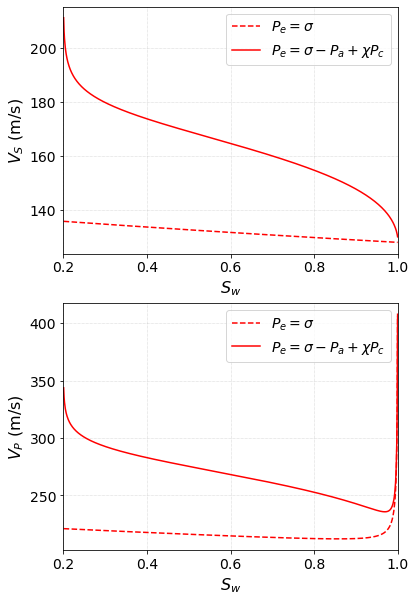

In [17]:
#Plot
fig, axs = plt.subplots(2,1, figsize=(6,10))
axs[0].plot(Sw, Vs_sat*1e3, 'r--', label='$P_e=\sigma$')
axs[0].plot(Sw, Vs_sat_c*1e3, 'r', label='$P_e=\sigma - P_a + \chi P_c$')
axs[1].plot(Sw, Vp_sat*1e3, 'r--', label='$P_e=\sigma$')
axs[1].plot(Sw, Vp_sat_c*1e3, 'r', label='$P_e=\sigma - P_a + \chi P_c$')
#Plot param
axs[0].set(ylabel='$V_S$ (m/s)', 
           xlabel='$S_w$', xlim=[Swr,1.])
axs[1].set(ylabel='$V_P$ (m/s)',
           xlabel='$S_w$', xlim=[Swr,1.])
for i in range(0,2):
    axs[i].grid()
    axs[i].legend()
plt.show()

#### Sensitivity to coordination number

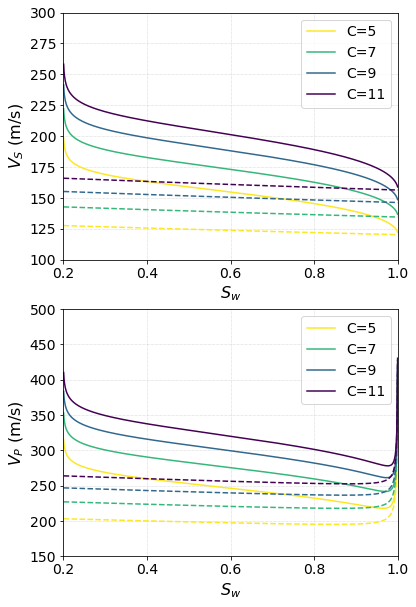

In [45]:
C_test = np.arange(5,12,2) #see Mavko's book, p.234

fig, axs = plt.subplots(2,1, figsize=(6,10))
color_map = 'viridis_r'
cmap = plt.get_cmap(color_map, len(C_test))

for (i,C) in enumerate(C_test):
    # Drained properties
    Kdr, Gdr = HertzMindlin(Ks, Gs, P, phi=phi, C=C, FC=FC)        #without capillary effects
    Kdr_c, Gdr_c = HertzMindlin(Ks, Gs, Peff, phi=phi, C=C, FC=FC) #with capillary effects
    
    # Saturated properties
    # -- without capillary effects
    Ksat = isoGassmann(Kdr, Gdr, Ks, Kf, phi)
    Vp_sat = Vp_from_K_G(Ksat, Gdr, rho_sat)
    Vs_sat = Vs_from_G(Gdr, rho_sat)
    # -- with capillary effects
    Ksat_c = isoGassmann(Kdr_c, Gdr_c, Ks, Kf, phi)
    Vp_sat_c = Vp_from_K_G(Ksat_c, Gdr_c, rho_sat)
    Vs_sat_c = Vs_from_G(Gdr_c, rho_sat)
    
    # Plot Vs,Vp = f(Sw)
    y_label_S = '$V_S$ (m/s)'
    y_label_P = '$V_P$ (m/s)'
    y_lim_S = [100,300]
    y_lim_P = [150,500]
    axs[0].plot(Sw, Vs_sat*1e3, 
                color=cmap(i), linestyle='--')
    axs[0].plot(Sw, Vs_sat_c*1e3, 
                color=cmap(i), label='C='+str(C))
    axs[1].plot(Sw, Vp_sat*1e3, 
                color=cmap(i), linestyle='--')
    axs[1].plot(Sw, Vp_sat_c*1e3, 
                color=cmap(i), label='C='+str(C))
#     # Plot DVs,DVp = f(Sw)
#     y_label_S = '$\Delta V_S /V_S$'
#     y_label_P = '$\Delta V_P /V_P$'
#     y_lim_S = [-0.3,0.5]
#     y_lim_P = [-0.2,1.2]
#     i_Sw = 399
#     axs[0].plot(Sw, (Vs_sat-Vs_sat[i_Sw])/Vs_sat[i_Sw], 
#                 color=cmap(i), linestyle='--')
#     axs[0].plot(Sw, (Vs_sat_c-Vs_sat_c[i_Sw])/Vs_sat_c[i_Sw], 
#                 color=cmap(i), label='C='+str(C))
#     axs[1].plot(Sw, (Vp_sat-Vp_sat[i_Sw])/Vp_sat[i_Sw], 
#                 color=cmap(i), linestyle='--')
#     axs[1].plot(Sw, (Vp_sat_c-Vp_sat_c[i_Sw])/Vp_sat_c[i_Sw], 
#                 color=cmap(i), label='C='+str(C))
    
#Plot param
axs[0].set(ylabel=y_label_S, 
           xlabel='$S_w$', xlim=[Swr,1.], ylim=y_lim_S)
axs[1].set(ylabel=y_label_P,
           xlabel='$S_w$', xlim=[Swr,1.], ylim=y_lim_P)
for i in range(0,2):
    axs[i].grid()
    axs[i].legend()
plt.show()

#### Sensitivity to friction coefficient

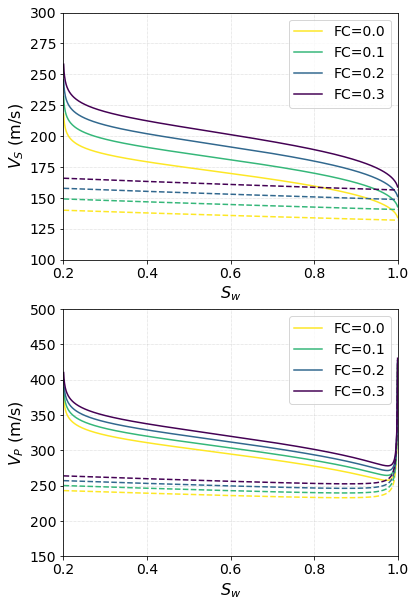

In [46]:
FC_test = np.arange(0,0.4,0.1)

fig, axs = plt.subplots(2,1, figsize=(6,10))
color_map = 'viridis_r'
cmap = plt.get_cmap(color_map, len(FC_test))

for (i,FC) in enumerate(FC_test):
    # Drained properties
    Kdr, Gdr = HertzMindlin(Ks, Gs, P, phi=phi, C=C, FC=FC)        #without capillary effects
    Kdr_c, Gdr_c = HertzMindlin(Ks, Gs, Peff, phi=phi, C=C, FC=FC) #with capillary effects
    
    # Saturated properties
    # -- without capillary effects
    Ksat = isoGassmann(Kdr, Gdr, Ks, Kf, phi)
    Vp_sat = Vp_from_K_G(Ksat, Gdr, rho_sat)
    Vs_sat = Vs_from_G(Gdr, rho_sat)
    # -- with capillary effects
    Ksat_c = isoGassmann(Kdr_c, Gdr_c, Ks, Kf, phi)
    Vp_sat_c = Vp_from_K_G(Ksat_c, Gdr_c, rho_sat)
    Vs_sat_c = Vs_from_G(Gdr_c, rho_sat)
    
    # Plot Vs,Vp = f(Sw)
    y_label_S = '$V_S$ (m/s)'
    y_label_P = '$V_P$ (m/s)'
    axs[0].plot(Sw, Vs_sat*1e3, 
                color=cmap(i), linestyle='--')
    axs[0].plot(Sw, Vs_sat_c*1e3, 
                color=cmap(i), label='FC={:.1f}'.format(FC))
    axs[1].plot(Sw, Vp_sat*1e3, 
                color=cmap(i), linestyle='--')
    axs[1].plot(Sw, Vp_sat_c*1e3, 
                color=cmap(i), label='FC={:.1f}'.format(FC))
#     # Plot DVs,DVp = f(Sw)
#     y_label_S = '$\Delta V_S /V_S$'
#     y_label_P = '$\Delta V_P /V_P$'
#     i_Sw = 399
#     axs[0].plot(Sw, (Vs_sat-Vs_sat[i_Sw])/Vs_sat[i_Sw], 
#                 color=cmap(i), linestyle='--')
#     axs[0].plot(Sw, (Vs_sat_c-Vs_sat_c[i_Sw])/Vs_sat_c[i_Sw], 
#                 color=cmap(i), label='FC='+str(FC))
#     axs[1].plot(Sw, (Vp_sat-Vp_sat[i_Sw])/Vp_sat[i_Sw], 
#                 color=cmap(i), linestyle='--')
#     axs[1].plot(Sw, (Vp_sat_c-Vp_sat_c[i_Sw])/Vp_sat_c[i_Sw], 
#                 color=cmap(i), label='FC='+str(FC))
    
#Plot param
axs[0].set(ylabel=y_label_S, 
           xlabel='$S_w$', xlim=[Swr,1.], ylim=y_lim_S)
axs[1].set(ylabel=y_label_P,
           xlabel='$S_w$', xlim=[Swr,1.], ylim=y_lim_P)
for i in range(0,2):
    axs[i].grid()
    axs[i].legend()
plt.show()

#### Sensitivity to pore size distribution parameter

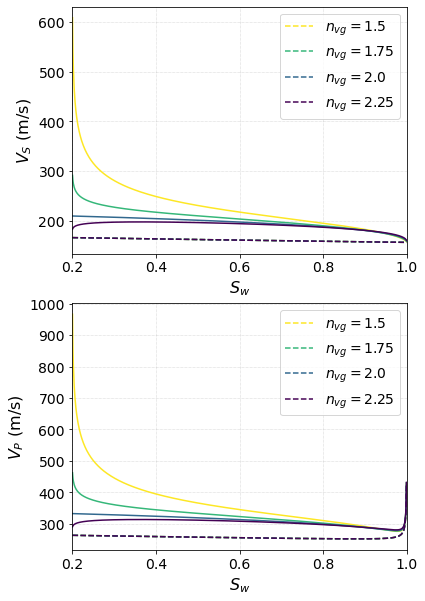

In [67]:
n_vg_test = np.arange(1.5,2.5,0.25)

fig, axs = plt.subplots(2,1, figsize=(6,10))
color_map = 'viridis_r'
cmap = plt.get_cmap(color_map, len(n_vg_test))

for (i,n_vg) in enumerate(n_vg_test):
    # Effective pressure with capillary effects
    Swe = (Sw-Swr)/(1-Swr) # effective water saturation (unitless), see discussion after Eq.8
    m_vg = 1-1/n_vg # pore size distribution parameter (unitless)
    h = -((Swe**(-1/m_vg)-1)/alpha_vg**(n_vg))**(1/n_vg) # hydraulic pressure head (m)
    Pa = (rho_a*1e3*g*z)*1e-6  #MPa 
    Pc = (-h*rho_w*1e3*g)*1e-6 #MPa
    Peff = P - Pa + Pc*Swe

    # Drained properties
    Kdr, Gdr = HertzMindlin(Ks, Gs, P, phi=phi, C=C, FC=FC)        #without capillary effects
    Kdr_c, Gdr_c = HertzMindlin(Ks, Gs, Peff, phi=phi, C=C, FC=FC) #with capillary effects

    # Saturated properties
    # -- without capillary effects
    Ksat = isoGassmann(Kdr, Gdr, Ks, Kf, phi)
    Vp_sat = Vp_from_K_G(Ksat, Gdr, rho_sat)
    Vs_sat = Vs_from_G(Gdr, rho_sat)
    # -- with capillary effects
    Ksat_c = isoGassmann(Kdr_c, Gdr_c, Ks, Kf, phi)
    Vp_sat_c = Vp_from_K_G(Ksat_c, Gdr_c, rho_sat)
    Vs_sat_c = Vs_from_G(Gdr_c, rho_sat)
    
    # Plot Vs,Vp = f(Sw)
    y_label_S = '$V_S$ (m/s)'
    y_label_P = '$V_P$ (m/s)'
    axs[0].plot(Sw, Vs_sat*1e3, 
                color=cmap(i), linestyle='--', label='$n_{vg}=$'+str(n_vg))
    axs[0].plot(Sw, Vs_sat_c*1e3, 
                color=cmap(i))
    axs[1].plot(Sw, Vp_sat*1e3, 
                color=cmap(i), linestyle='--', label='$n_{vg}=$'+str(n_vg))
    axs[1].plot(Sw, Vp_sat_c*1e3, 
                color=cmap(i))
    
#Plot param
axs[0].set(ylabel=y_label_S, 
           xlabel='$S_w$', xlim=[Swr,1.])
axs[1].set(ylabel=y_label_P,
           xlabel='$S_w$', xlim=[Swr,1.])
for i in range(0,2):
    axs[i].grid()
    axs[i].legend()
plt.show()

#### Sensitivity to pore entry pressure

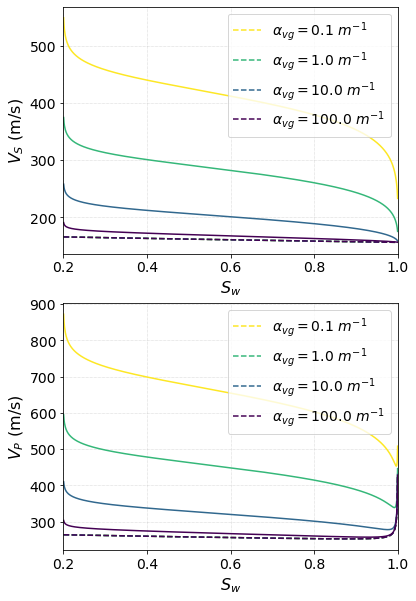

In [78]:
n_vg = 1.82 # reinitialize n_vg to mean between Missouri clay and Esperance Sand
alpha_vg_test = np.logspace(-1,2,4)

fig, axs = plt.subplots(2,1, figsize=(6,10))
color_map = 'viridis_r'
cmap = plt.get_cmap(color_map, len(n_vg_test))

for (i,alpha_vg) in enumerate(alpha_vg_test):
    # Effective pressure with capillary effects
    Swe = (Sw-Swr)/(1-Swr) # effective water saturation (unitless), see discussion after Eq.8
    m_vg = 1-1/n_vg # pore size distribution parameter (unitless)
    h = -((Swe**(-1/m_vg)-1)/alpha_vg**(n_vg))**(1/n_vg) # hydraulic pressure head (m)
    Pa = (rho_a*1e3*g*z)*1e-6  #MPa 
    Pc = (-h*rho_w*1e3*g)*1e-6 #MPa
    Peff = P - Pa + Pc*Swe

    # Drained properties
    Kdr, Gdr = HertzMindlin(Ks, Gs, P, phi=phi, C=C, FC=FC)        #without capillary effects
    Kdr_c, Gdr_c = HertzMindlin(Ks, Gs, Peff, phi=phi, C=C, FC=FC) #with capillary effects

    # Saturated properties
    # -- without capillary effects
    Ksat = isoGassmann(Kdr, Gdr, Ks, Kf, phi)
    Vp_sat = Vp_from_K_G(Ksat, Gdr, rho_sat)
    Vs_sat = Vs_from_G(Gdr, rho_sat)
    # -- with capillary effects
    Ksat_c = isoGassmann(Kdr_c, Gdr_c, Ks, Kf, phi)
    Vp_sat_c = Vp_from_K_G(Ksat_c, Gdr_c, rho_sat)
    Vs_sat_c = Vs_from_G(Gdr_c, rho_sat)
    
    # Plot Vs,Vp = f(Sw)
    y_label_S = '$V_S$ (m/s)'
    y_label_P = '$V_P$ (m/s)'
    axs[0].plot(Sw, Vs_sat*1e3, 
                color=cmap(i), linestyle='--', label='$\\alpha_{vg}=$'+str(alpha_vg)+' $m^{-1}$')
    axs[0].plot(Sw, Vs_sat_c*1e3, 
                color=cmap(i))
    axs[1].plot(Sw, Vp_sat*1e3, 
                color=cmap(i), linestyle='--', label='$\\alpha_{vg}=$'+str(alpha_vg)+' $m^{-1}$')
    axs[1].plot(Sw, Vp_sat_c*1e3, 
                color=cmap(i))
    
#Plot param
axs[0].set(ylabel=y_label_S, 
           xlabel='$S_w$', xlim=[Swr,1.])
axs[1].set(ylabel=y_label_P,
           xlabel='$S_w$', xlim=[Swr,1.])
for i in range(0,2):
    axs[i].grid()
    axs[i].legend()
plt.show()